# Some functions to calculate gs_model and plots

In [1]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os
from shutil import copyfile
from gs_util import read_forcing,modify_attr,cal_gs_obs,IQR_compare,obs_sim,cal_gs_mod,gs_plot_test,modify_attr_2,func_parse_date

# Preparing the data (obs and model)

In [2]:
name='CA-Obs' 
year=2008
df_forcing= read_forcing(name,year)

In [3]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
df_state_init,level=modify_attr(df_state_init,name)
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]
grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

2019-10-30 18:49:11,824 — SuPy — INFO — All cache cleared.
2019-10-30 18:49:14,217 — SuPy — INFO — All cache cleared.


In [4]:
error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2019-10-30 18:49:15,489 — SuPy — INFO — ====================
2019-10-30 18:49:15,494 — SuPy — INFO — Simulation period:
2019-10-30 18:49:15,497 — SuPy — INFO —   Start: 2007-12-31 23:05:00
2019-10-30 18:49:15,499 — SuPy — INFO —   End: 2008-12-31 23:00:00
2019-10-30 18:49:15,507 — SuPy — INFO — 
2019-10-30 18:49:15,511 — SuPy — INFO — No. of grids: 1
2019-10-30 18:49:15,512 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:49:23,521 — SuPy — INFO — Execution time: 8.0 s
2019-10-30 18:49:23,522 — SuPy — INFO — ====================

352.97912858314277
2019-10-30 18:49:23,935 — SuPy — INFO — ====================
2019-10-30 18:49:23,936 — SuPy — INFO — Simulation period:
2019-10-30 18:49:23,936 — SuPy — INFO —   Start: 2007-12-31 23:05:00
2019-10-30 18:49:23,937 — SuPy — INFO —   End: 2008-12-31 23:00:00
2019-10-30 18:49:23,937 — SuPy — INFO — 
2019-10-30 18:49:23,939 — SuPy — INFO — No. of grids: 1
2019-10-30 18:49:23,940 — SuPy — INFO — SuPy is running in serial mode
2019-10-3

In [5]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()

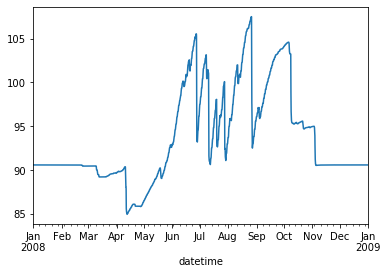

In [6]:
df.SMD.plot()

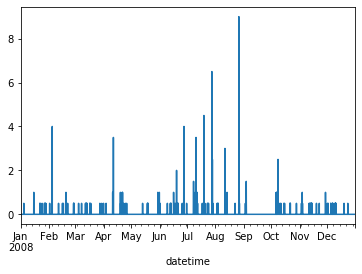

In [7]:
df_forcing.rain.plot()

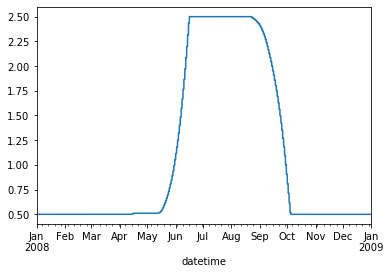

In [8]:
df.LAI.plot()

In [9]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[df_forcing.qe > 0]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)
df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

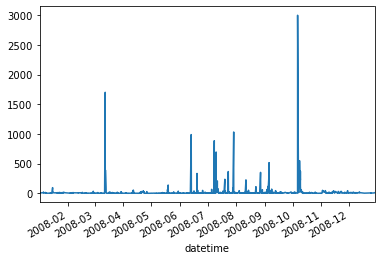

In [10]:
gs_obs.plot()

(-50, 400)

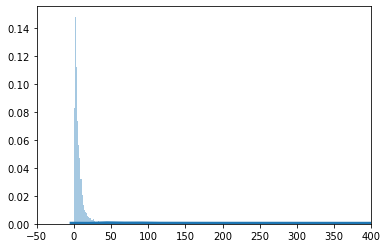

In [11]:
sns.distplot(gs_obs.values,hist=True, kde=True,bins=int(2000),kde_kws={'linewidth': 4})
plt.xlim((-50,400))

In [12]:
g_max=np.percentile(gs_obs,99)
s1=5.56

In [13]:
g_max

102.85140201916374

In [14]:
df_forcing=df_forcing[gs_obs<g_max]
#lai_max=df_forcing.lai.max()
lai_max=df_state_init.laimax.loc[grid,:][0]
gs_obs=gs_obs[gs_obs<g_max]


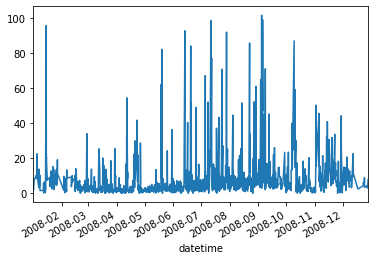

In [15]:
gs_obs.plot()

In [16]:
lai_max

2.5

# Splitting the data to test and train

In [17]:
df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [18]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

# Optimization

## More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [19]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [20]:
problem = Problem(6,2,1)
problem.types[0] = Real(.05, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(0.02, 0.03)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
#algorithm=NSGAIII(problem, divisions_outer=12)
algorithm.run(3000)


In [21]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.510	0.820
0.124	1.194
0.049	1.281
0.013	1.323
0.168	1.144
0.472	0.849
0.323	0.982
0.138	1.179
0.028	1.306
0.539	0.799


## It shows how two objective changes

Text(0, 0.5, 'objective 2')

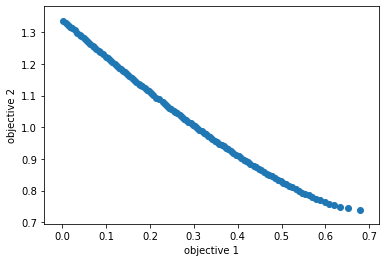

In [22]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

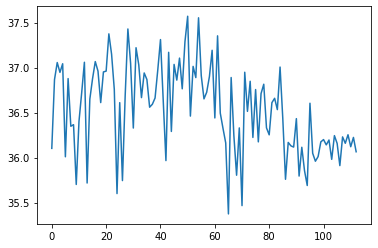

In [23]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [24]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

## Choosing between : the median of two objectives, where obj1 is max or where obj2 is max

In [25]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.2877684874360835
1.0179812379755446


In [26]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [27]:
with open('g1-g6/'+name+'-g1-g6','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [28]:
with open('g1-g6/'+name+'-g1-g6','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [29]:

pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
CA-Obs,0.229,104.413,0.482,0.696,36.253,0.024


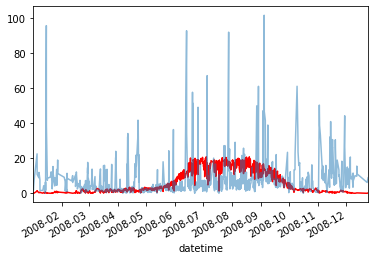

In [30]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

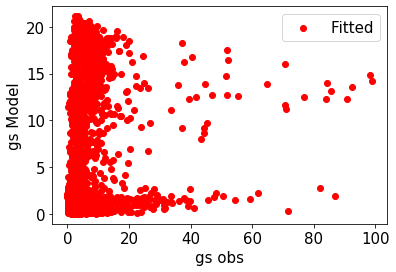

In [31]:
kd_test=df_forcing_test.kdown
ta_test=df_forcing_test.Tair
rh_test=df_forcing_test.RH
pa_test=df_forcing_test.pres
smd_test=df_forcing_test.xsmd
lai_test=df_forcing_test.lai



gs_model_test,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
# gs_model_helen,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
#                           [3.5, 200, 0.13, 0.7, 30, .05],
#                           g_max, lai_max, s1)

plt.rc('font', size=15)
f, ax = plt.subplots(1, 1)
plt.scatter(gs_test.values,gs_model_test.values,color='r',alpha=1,label='Fitted')
#plt.scatter(gs_test.values,gs_model_helen.values,color='b',alpha=0.4,label='Helen')
plt.xlabel('gs obs')
plt.ylabel('gs Model')
plt.legend()
plt.savefig('figs/compare_test-gs-'+name+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)


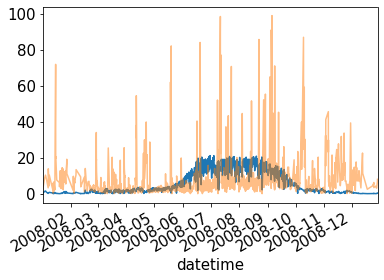

In [32]:
gs_model_test.plot()
gs_test.plot(alpha=0.5)

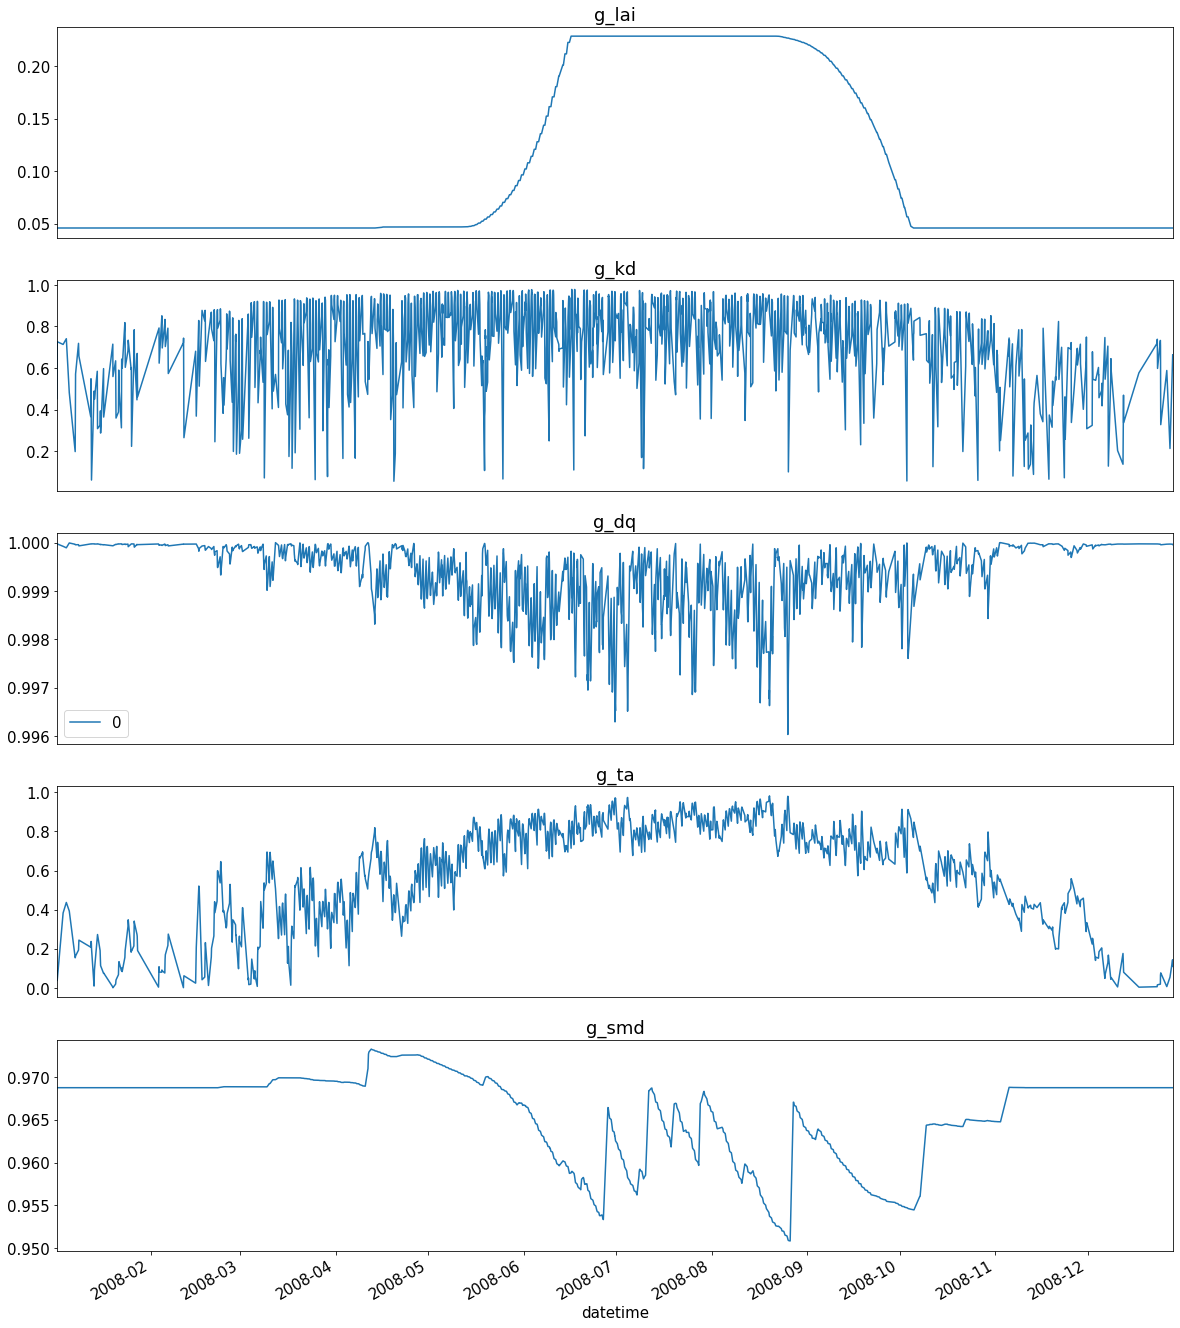

In [33]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')
    
    

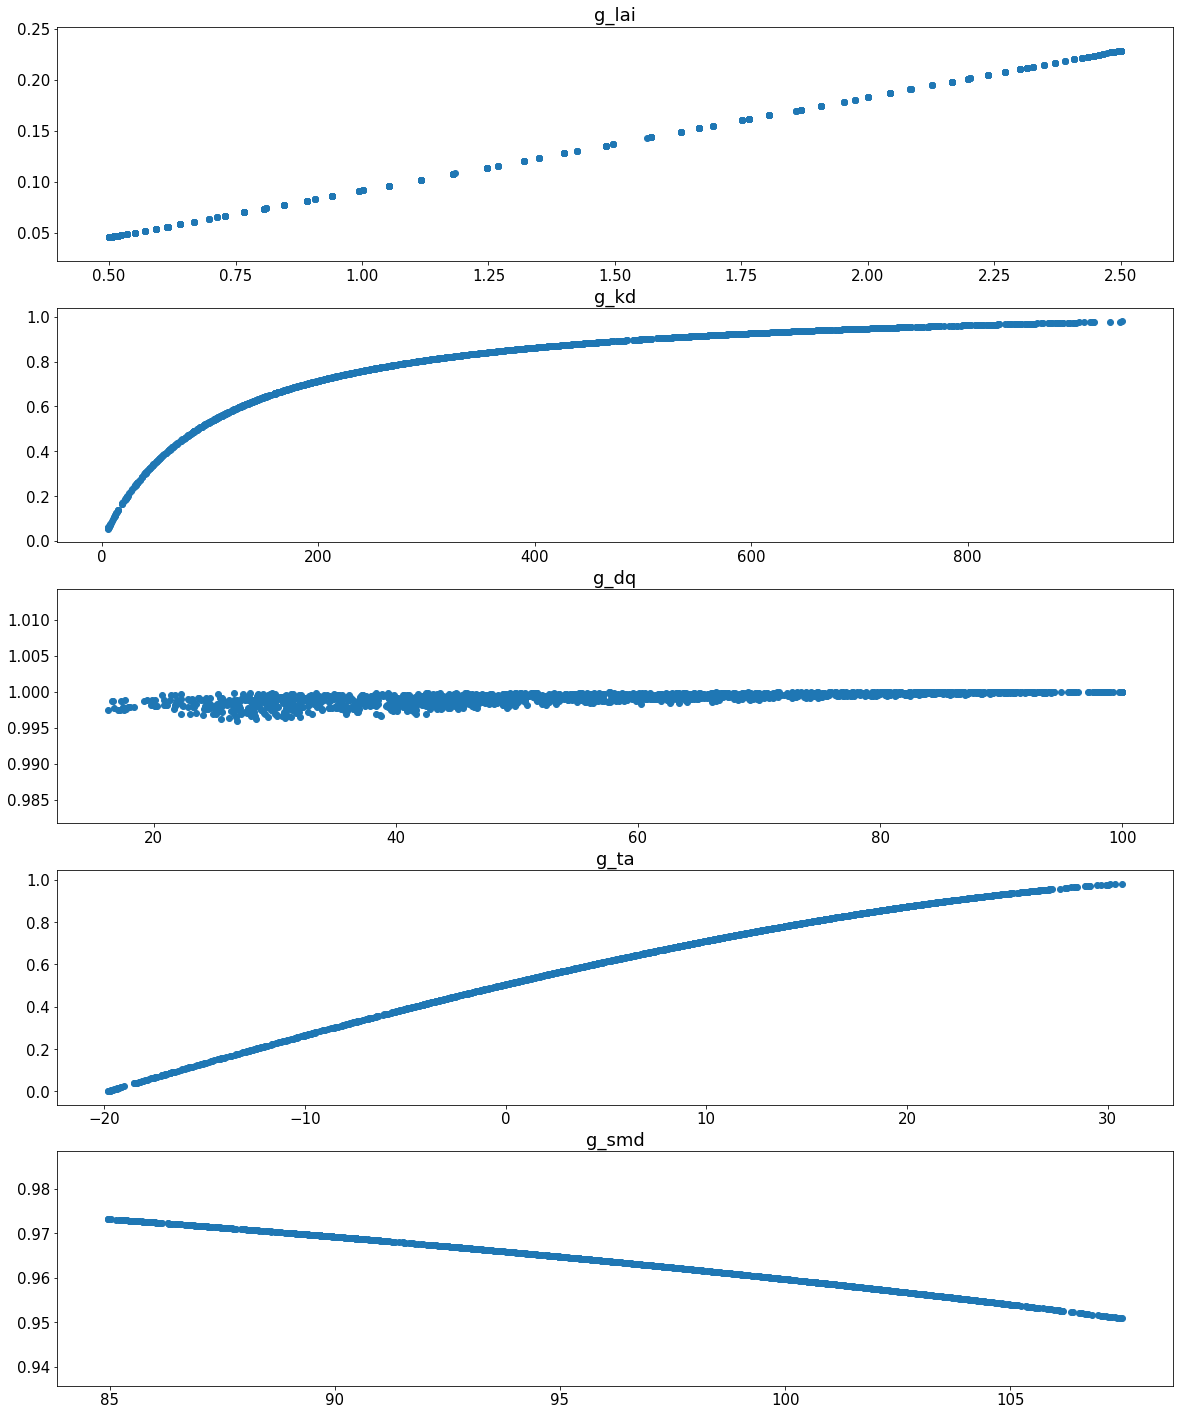

In [34]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
c={'0':lai_test,'1':kd_test,'2':rh_test,'3':ta_test-273,'4':smd_test}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    ax.scatter(c[str(i)],a[str(i)])
    ax.set_title(b[str(i)])
    if i!=4:
        #ax.set_xticks([''])
        ax.set_xlabel('')
    
    

In [35]:
print(abs(gs_model_test-gs_test).mean())

7.196918889252198


## Running Supy with new g1-g6

2019-10-30 18:53:07,155 — SuPy — INFO — All cache cleared.
2019-10-30 18:53:08,278 — SuPy — INFO — All cache cleared.
2019-10-30 18:53:09,513 — SuPy — INFO — ====================
2019-10-30 18:53:09,514 — SuPy — INFO — Simulation period:
2019-10-30 18:53:09,515 — SuPy — INFO —   Start: 2007-12-31 23:05:00
2019-10-30 18:53:09,516 — SuPy — INFO —   End: 2008-12-31 23:00:00
2019-10-30 18:53:09,516 — SuPy — INFO — 
2019-10-30 18:53:09,518 — SuPy — INFO — No. of grids: 1
2019-10-30 18:53:09,519 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:53:19,115 — SuPy — INFO — Execution time: 9.6 s
2019-10-30 18:53:19,116 — SuPy — INFO — ====================



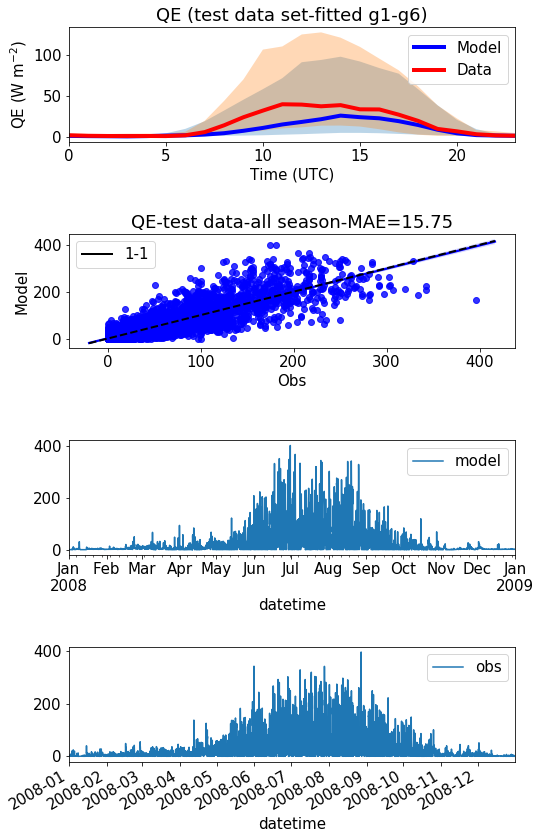

In [41]:
alpha=0.94
name='CA-Obs'
year=year
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha)

In [42]:
g1=g1*alpha

In [43]:
g1*g_max

22.133721379690183

In [44]:
g_max=g1*g_max
g1=1


In [45]:
g_max

22.133721379690183

### looking at each season

In [46]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

df_state_init.g1=g1
df_state_init.g2=g2
df_state_init.g3=g3
df_state_init.g4=g4
df_state_init.g5=g5
df_state_init.g6=g6


df_state_init,level=modify_attr(df_state_init,name)
f_state_init=modify_attr_2(df_state_init,g_max,s1)

df_output, df_state_final = sp.run_supy(df_forcing, df_state_init, save_state=False)

2019-10-30 18:53:28,396 — SuPy — INFO — All cache cleared.
2019-10-30 18:53:29,356 — SuPy — INFO — All cache cleared.
2019-10-30 18:53:30,780 — SuPy — INFO — ====================
2019-10-30 18:53:30,780 — SuPy — INFO — Simulation period:
2019-10-30 18:53:30,781 — SuPy — INFO —   Start: 2007-12-31 23:05:00
2019-10-30 18:53:30,782 — SuPy — INFO —   End: 2008-12-31 23:00:00
2019-10-30 18:53:30,783 — SuPy — INFO — 
2019-10-30 18:53:30,785 — SuPy — INFO — No. of grids: 1
2019-10-30 18:53:30,786 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:53:39,560 — SuPy — INFO — Execution time: 8.8 s
2019-10-30 18:53:39,561 — SuPy — INFO — ====================



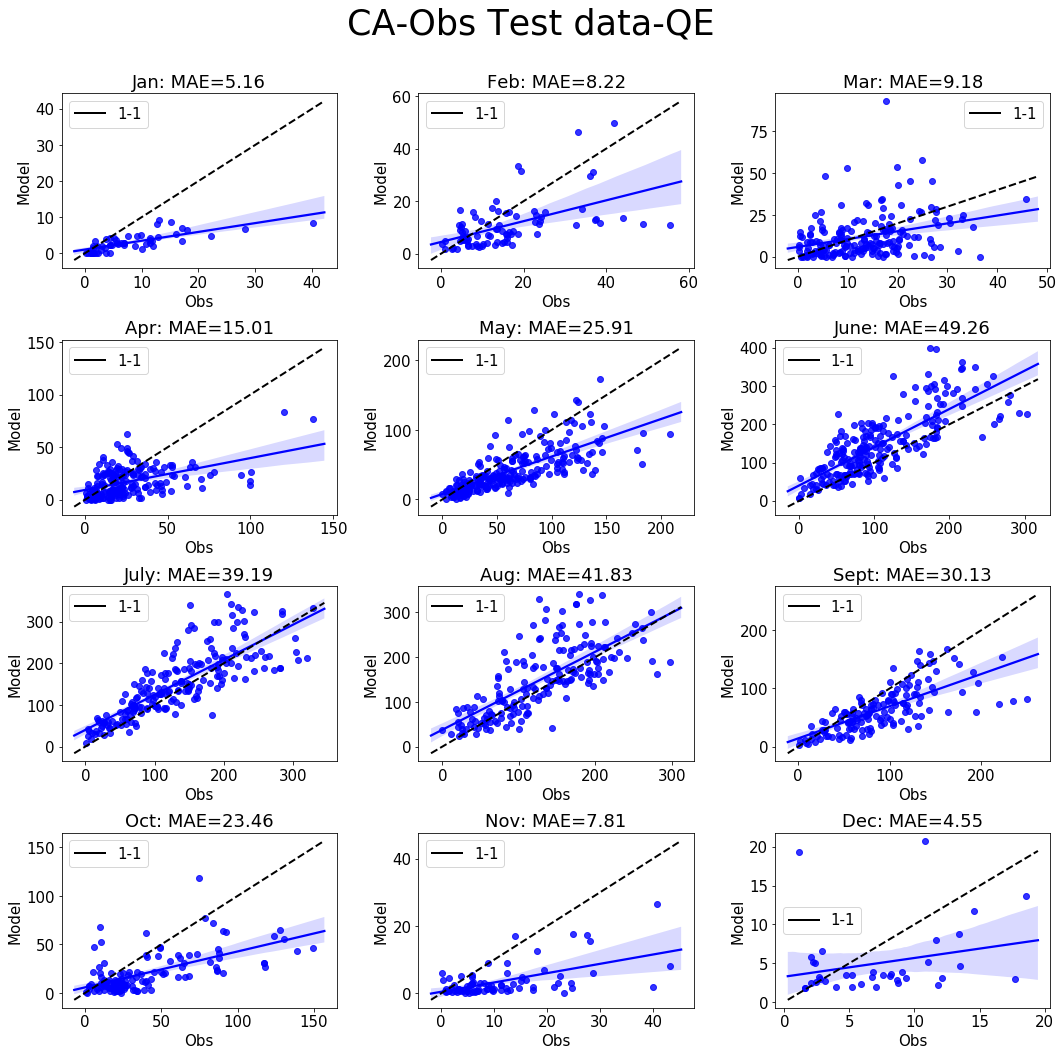

In [47]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()
df_temp=df_forcing_test.replace(-999,np.nan)
df=df.loc[df_temp.index,:]
months_model = [g for n, g in df.groupby(pd.Grouper(freq='M'))]
plt.rc('font', size=15)
f=plt.figure(figsize=(15,15))
f.suptitle(name+' Test data-QE',size=35)

month_name=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
for i in range(0,12):
    plt.rc('font', size=15)
    ax=plt.subplot(4,3,i+1)
    obs_sim('qe','QE',df_temp,months_model[i],ax)

    plt.ylabel('Model')
    plt.xlabel('Obs')
    plt.title(month_name[i]+': MAE='+str(np.round(np.mean(abs(months_model[i].QE-df_temp.qe)),2)))
plt.tight_layout()
f.subplots_adjust(top=.9)

2019-10-30 18:53:44,932 — SuPy — INFO — ====================
2019-10-30 18:53:44,933 — SuPy — INFO — Simulation period:
2019-10-30 18:53:44,934 — SuPy — INFO —   Start: 2007-12-31 23:05:00
2019-10-30 18:53:44,934 — SuPy — INFO —   End: 2008-12-31 23:00:00
2019-10-30 18:53:44,935 — SuPy — INFO — 
2019-10-30 18:53:44,936 — SuPy — INFO — No. of grids: 1
2019-10-30 18:53:44,938 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:53:53,679 — SuPy — INFO — Execution time: 8.7 s
2019-10-30 18:53:53,680 — SuPy — INFO — ====================



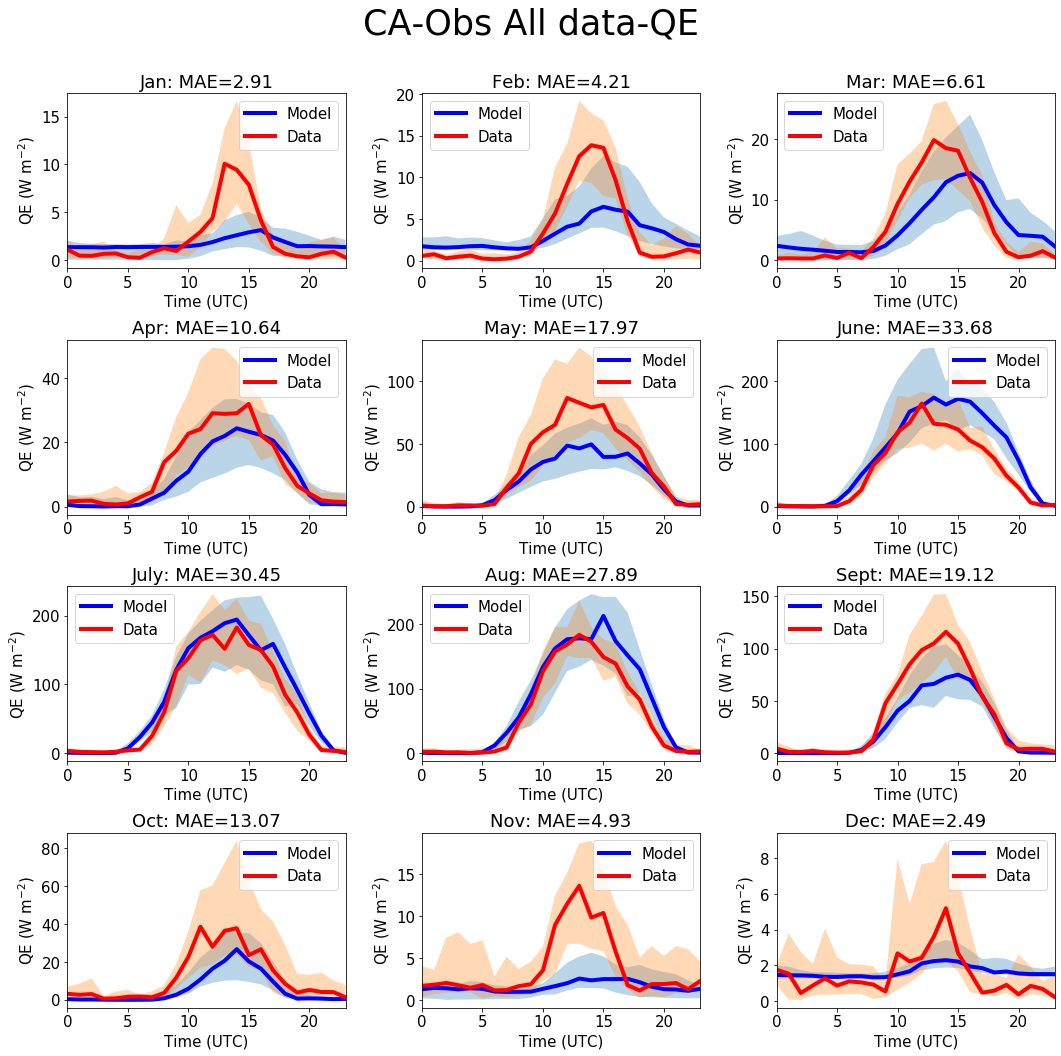

In [48]:
df_obs=pd.read_csv('runs/run'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

df_obs= df_obs.set_index('datetime')
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init, save_state=False)
df_obs_temp=df_obs.replace(-999,np.nan)
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()
months_model = [g for n, g in df.groupby(pd.Grouper(freq='M'))]
plt.rc('font', size=15)
f=plt.figure(figsize=(15,15))
f.suptitle(name+' All data-QE',size=35)
month_name=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
for i in range(0,12):
    plt.rc('font', size=15)
    ax=plt.subplot(4,3,i+1)
    IQR_compare('qe','QE',df_obs_temp.loc[months_model[i].index,:],months_model[i],ax)

    plt.ylabel('QE (W m$^{-2}$)')
    plt.xlabel('Time (UTC)')
    plt.legend()
    plt.title(month_name[i]+': MAE='+str(np.round(np.mean(abs(months_model[i].QE-df_obs_temp.qe)),2)))
plt.tight_layout()
f.subplots_adjust(top=.9)


# Creating the table for all sites here

In [49]:
sites=['Swindon','London','US-MMS','US-Blk','US-SRG','CA-Obs','Kc','Sw']
g1_g6_all=pd.DataFrame(columns=['g1','g2','g3','g4','g5','g6'])

for s in sites:
    with open('g1-g6/'+s+'-g1-g6','rb') as f:
        g1_g6_all.loc[s,:]=pickle.load(f)
g1_g6_all  

,g1,g2,g3,g4,g5,g6
Swindon,2.46186,111.283,0.649472,0.263545,1.22068,0.0972639
London,4.45704,104.601,0.439791,0.594791,20.3764,0.0766758
US-MMS,0.325157,104.655,0.46715,0.708875,36.2812,0.0293148
US-Blk,1,267.197,0.162215,0.641343,34.6575,0.0200774
US-SRG,1,266.156,0.779166,0.739141,18.0336,0.0383004
CA-Obs,0.228937,104.413,0.482281,0.695792,36.2528,0.0243644
Kc,1,251.15,0.528526,0.735862,1.58365,0.0316655
Sw,1,266.441,0.40109,0.00885994,16.0812,0.0971404


In [50]:
g_max

22.133721379690183

# To test

## CA-Obs-2006

In [51]:
g_max=22.133721379690183

2019-10-30 18:54:20,055 — SuPy — INFO — All cache cleared.
2019-10-30 18:54:20,909 — SuPy — INFO — All cache cleared.
2019-10-30 18:54:22,072 — SuPy — INFO — ====================
2019-10-30 18:54:22,073 — SuPy — INFO — Simulation period:
2019-10-30 18:54:22,073 — SuPy — INFO —   Start: 2005-12-31 23:05:00
2019-10-30 18:54:22,074 — SuPy — INFO —   End: 2006-12-31 23:00:00
2019-10-30 18:54:22,075 — SuPy — INFO — 
2019-10-30 18:54:22,076 — SuPy — INFO — No. of grids: 1
2019-10-30 18:54:22,078 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:54:33,753 — SuPy — INFO — Execution time: 11.7 s
2019-10-30 18:54:33,754 — SuPy — INFO — ====================



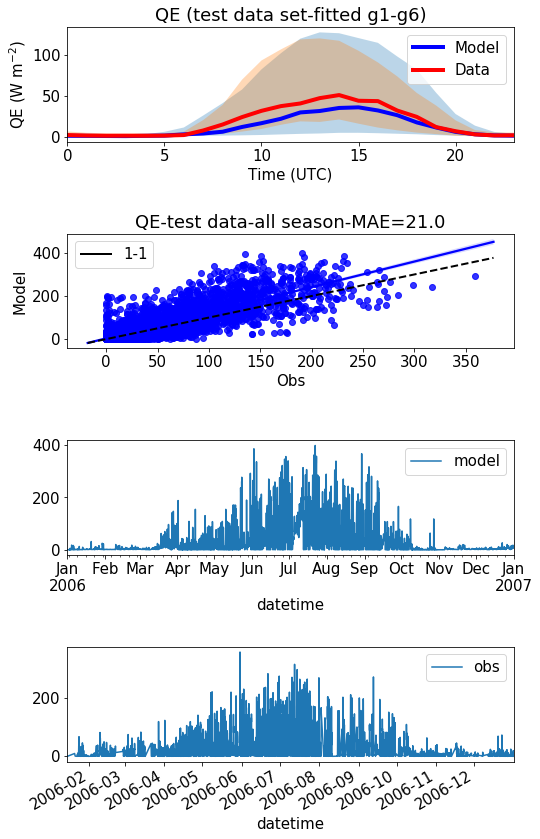

In [52]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56


name='CA-Obs'
year=2006
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

## US-Blk-2006

2019-10-30 18:54:48,789 — SuPy — INFO — All cache cleared.
2019-10-30 18:54:49,769 — SuPy — INFO — All cache cleared.
2019-10-30 18:54:50,916 — SuPy — INFO — ====================
2019-10-30 18:54:50,917 — SuPy — INFO — Simulation period:
2019-10-30 18:54:50,918 — SuPy — INFO —   Start: 2005-12-31 23:05:00
2019-10-30 18:54:50,919 — SuPy — INFO —   End: 2006-12-31 23:00:00
2019-10-30 18:54:50,920 — SuPy — INFO — 
2019-10-30 18:54:50,921 — SuPy — INFO — No. of grids: 1
2019-10-30 18:54:50,922 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:56:55,645 — SuPy — INFO — Execution time: 124.7 s
2019-10-30 18:56:55,646 — SuPy — INFO — ====================



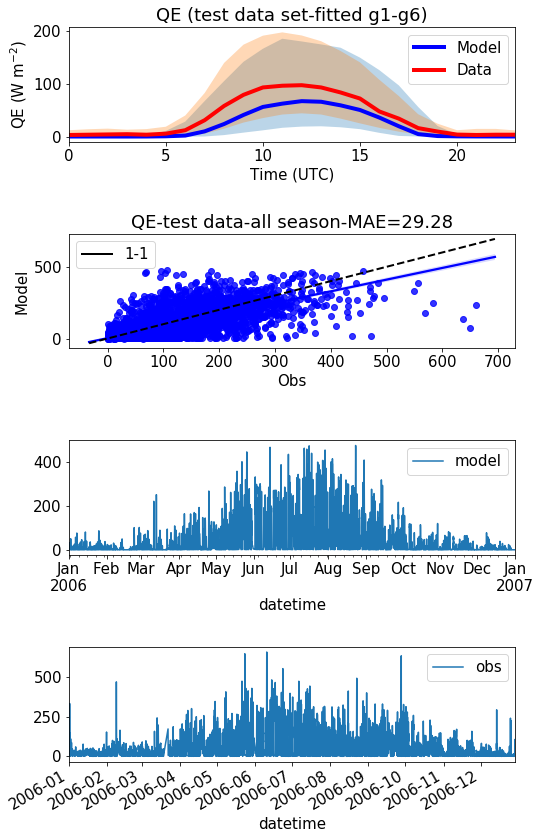

In [53]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='US-Blk'
year=2006
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

## CA-Qcu-2005

2019-10-30 18:57:27,200 — SuPy — INFO — All cache cleared.
2019-10-30 18:57:28,381 — SuPy — INFO — All cache cleared.
2019-10-30 18:57:30,104 — SuPy — INFO — ====================
2019-10-30 18:57:30,105 — SuPy — INFO — Simulation period:
2019-10-30 18:57:30,106 — SuPy — INFO —   Start: 2004-12-31 23:05:00
2019-10-30 18:57:30,106 — SuPy — INFO —   End: 2005-12-31 23:00:00
2019-10-30 18:57:30,107 — SuPy — INFO — 
2019-10-30 18:57:30,109 — SuPy — INFO — No. of grids: 1
2019-10-30 18:57:30,109 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:57:41,428 — SuPy — INFO — Execution time: 11.3 s
2019-10-30 18:57:41,431 — SuPy — INFO — ====================



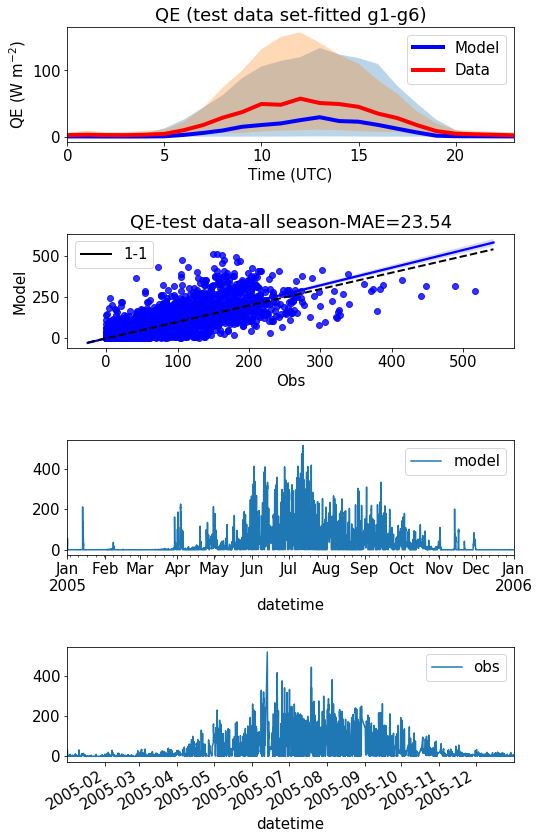

In [54]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='CA-Qcu'
year=2005
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

# With Helen's

## CA-Obs-2006

2019-10-30 18:58:02,590 — SuPy — INFO — All cache cleared.
2019-10-30 18:58:03,536 — SuPy — INFO — All cache cleared.
2019-10-30 18:58:04,884 — SuPy — INFO — ====================
2019-10-30 18:58:04,885 — SuPy — INFO — Simulation period:
2019-10-30 18:58:04,886 — SuPy — INFO —   Start: 2005-12-31 23:05:00
2019-10-30 18:58:04,887 — SuPy — INFO —   End: 2006-12-31 23:00:00
2019-10-30 18:58:04,888 — SuPy — INFO — 
2019-10-30 18:58:04,891 — SuPy — INFO — No. of grids: 1
2019-10-30 18:58:04,894 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:58:17,042 — SuPy — INFO — Execution time: 12.2 s
2019-10-30 18:58:17,044 — SuPy — INFO — ====================



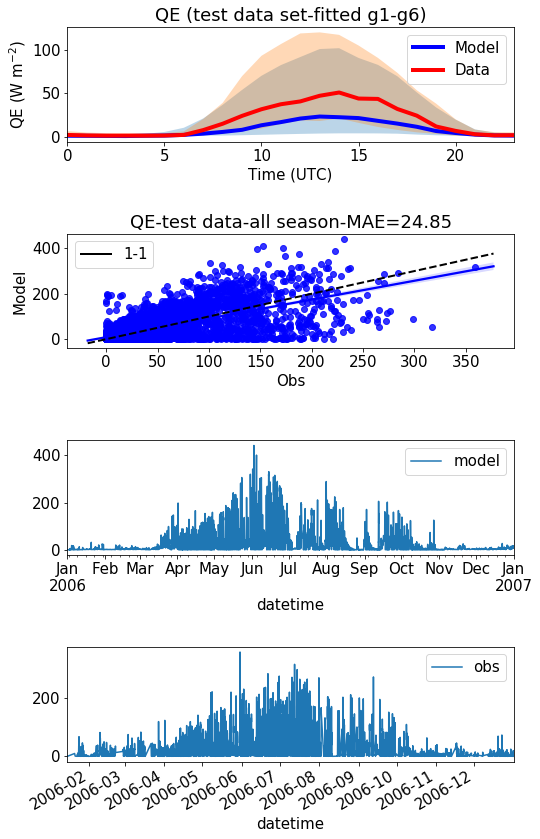

In [55]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56

name='CA-Obs'
year=2006
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1,helen=1)

## US-Blk 2006

2019-10-30 18:58:21,785 — SuPy — INFO — All cache cleared.
2019-10-30 18:58:22,627 — SuPy — INFO — All cache cleared.
2019-10-30 18:58:23,764 — SuPy — INFO — ====================
2019-10-30 18:58:23,765 — SuPy — INFO — Simulation period:
2019-10-30 18:58:23,766 — SuPy — INFO —   Start: 2005-12-31 23:05:00
2019-10-30 18:58:23,767 — SuPy — INFO —   End: 2006-12-31 23:00:00
2019-10-30 18:58:23,768 — SuPy — INFO — 
2019-10-30 18:58:23,769 — SuPy — INFO — No. of grids: 1
2019-10-30 18:58:23,771 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 18:59:47,024 — SuPy — INFO — Execution time: 83.3 s
2019-10-30 18:59:47,025 — SuPy — INFO — ====================



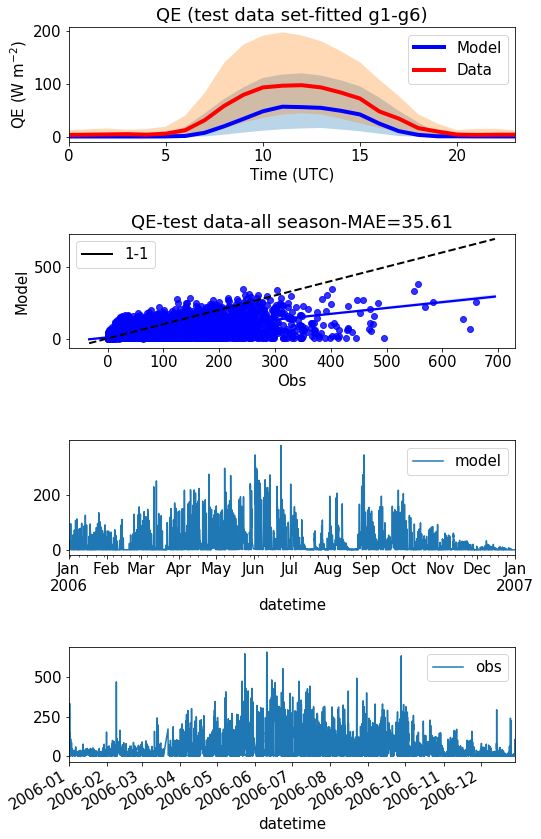

In [56]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56

name='US-Blk'
year=2006
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1,helen=1)

## CA-Qcu 2005

2019-10-30 18:59:51,503 — SuPy — INFO — All cache cleared.
2019-10-30 18:59:52,352 — SuPy — INFO — All cache cleared.
2019-10-30 18:59:53,504 — SuPy — INFO — ====================
2019-10-30 18:59:53,504 — SuPy — INFO — Simulation period:
2019-10-30 18:59:53,505 — SuPy — INFO —   Start: 2004-12-31 23:05:00
2019-10-30 18:59:53,506 — SuPy — INFO —   End: 2005-12-31 23:00:00
2019-10-30 18:59:53,507 — SuPy — INFO — 
2019-10-30 18:59:53,508 — SuPy — INFO — No. of grids: 1
2019-10-30 18:59:53,509 — SuPy — INFO — SuPy is running in serial mode
2019-10-30 19:00:03,073 — SuPy — INFO — Execution time: 9.6 s
2019-10-30 19:00:03,074 — SuPy — INFO — ====================



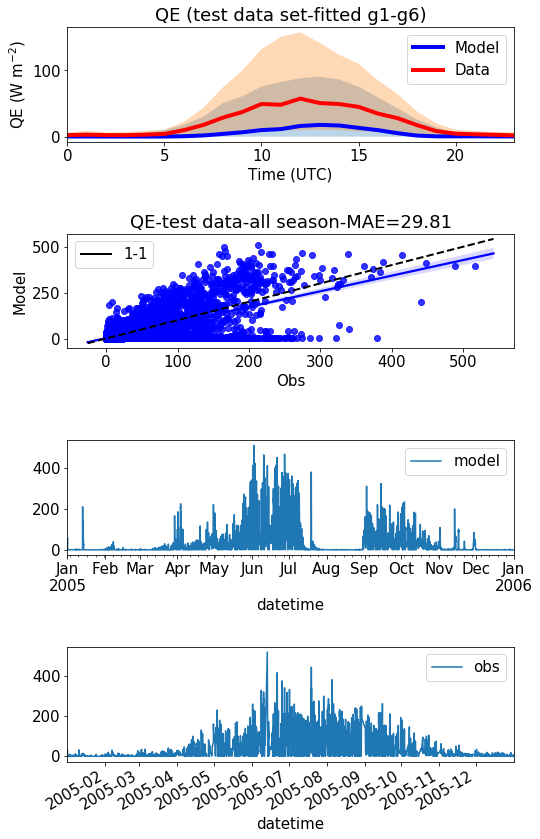

In [57]:
g1,g2,g3,g4,g5,g6=[3.5, 200, 0.13, 0.7, 30, .05]
g_max=33
s1=5.56


name='CA-Qcu'
year=2005
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1,helen=1)